In [53]:
import glob
import os

import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
from einops import rearrange
import random
import sigpy as sp
from utils import prep_nufft
from radial_lsfp import MCNUFFT
import time
from utils import to_torch_complex

class SliceDataset(Dataset):
    """
    A Dataset that:
      - Looks for all .h5/.hdf5 files under `root_dir`.
      - Each file is assumed to contain a dataset at `dataset_key`, with shape (... Z),
        where Z is the number of slices/partitions.
      - Splits each volume into Z separate examples (one per slice).
      - Returns each slice as a torch.Tensor.
    """

    def __init__(
        self,
        root_dir,
        patient_ids,
        dataset_key="kspace",
        file_pattern="*.h5",
        slice_idx=41,
        N_time = 8,
        N_coils=16
    ):
        """
        Args:
            root_dir (str): Path to the folder containing all HDF5 k-space files.
            dataset_key (str): The key/path inside each .h5 file to the k-space dataset (e.g. "kspace").
            file_pattern (str): Glob pattern to match your HDF5 files (default "*.h5").
        """
        super().__init__()
        self.root_dir = root_dir
        self.dataset_key = dataset_key
        self.slice_idx = slice_idx
        self.N_time = N_time
        self.N_coils = N_coils

        # Find all matching HDF5 files under root_dir
        all_files = sorted(glob.glob(os.path.join(root_dir, file_pattern)))
        print("Number of files in root directory: ", len(all_files))

        if len(all_files) == 0:
            raise RuntimeError(
                f"No files found in {root_dir} matching pattern {file_pattern}"
            )

        # filter file list by patient ID substring
        filtered = []
        for fp in all_files:
            fname = os.path.basename(fp)
            # Check if any patient_id appears in the filename
            if any(pid in fname for pid in patient_ids):
                filtered.append(fp)

        self.file_list = filtered

        if len(self.file_list) == 0:
            raise RuntimeError("No files matched the provided patient_ids filter.")

        # Build a list of (file_path, slice_index) for every slice in every volume
        # self.slice_index_map = []
        # for fp in self.file_list:
        #     with h5py.File(fp, "r") as f:
        #         if self.dataset_key not in f:
        #             raise KeyError(f"Dataset key '{self.dataset_key}' not found in file {fp}")
        #         ds = f[self.dataset_key]
        #         num_slices = ds.shape[0]

        #     for z in range(num_slices):
        #         self.slice_index_map.append((fp, z))

    def load_dynamic_img(self, patient_id):

        H = W = 320
        data = np.empty((2, self.N_time, H, W), dtype=np.float32)

        for t in range(self.N_time):
            # load image 
            img_path = f'/ess/scratch/scratch1/rachelgordon/dce-{self.N_time}tf/{patient_id}/slice_{self.slice_idx:03d}_frame_{t:03d}.nii'

            # if os.path.exists(img_path):

            img = nib.load(img_path)
            img_data = img.get_fdata()

            if img_data.shape != (2, H, W):
                raise ValueError(f"{img_path} has shape {img_data.shape}; "
                                f"expected (2, {H}, {W})")

            data[:, t] = img_data.astype(np.float32)
            
            # else:
            #     return None

        return torch.from_numpy(data) 
    
    def load_csmaps(self, patient_id):

        ground_truth_dir = os.path.join(os.path.dirname(self.root_dir), 'cs_maps')
        csmap_path = os.path.join(ground_truth_dir, patient_id + '_cs_maps', f'cs_map_slice_{self.slice_idx:03d}.npy')

        csmap = np.load(csmap_path)

        return csmap.squeeze()


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        """
        Returns a single slice of k-space as a torch.Tensor.
        The output shape will be the standard (C=2, T, S, I) where C is [real, imag].
        """

        # load GRASP recon image
        file_path = self.file_list[idx]
        patient_id = file_path.split('/')[-1].strip('.h5')

        grasp_img = self.load_dynamic_img(patient_id)
        csmap = self.load_csmaps(patient_id)

        with h5py.File(file_path, "r") as f:
            ds = torch.tensor(f[self.dataset_key][:])
            kspace_slice = ds[self.slice_idx]

        # Select the first coil
        if self.N_coils == 1:
            kspace_slice = kspace_slice[:, 0, :, :]  # Shape: (T, S, I)

        # Separate real and imaginary components
        real_part = kspace_slice.real
        imag_part = kspace_slice.imag

        # Stack them along a new 'channel' dimension (dim=0).
        # This creates the final, standard (C=2, T, S, I) format.
        kspace_final = torch.stack([real_part, imag_part], dim=0).float()

        N_samples = kspace_final.shape[-1]
        spokes_per_frame = kspace_final.shape[-2]


        # rotate to match orientation of validation set 
        # kspace_final = torch.rot90(kspace_final, k=2, dims=[-2, -1])
        kspace_final = torch.flip(kspace_final, dims=[-1])

        # You MUST also rotate the corresponding csmaps and grasp_img
        # csmap shape is likely (H, W, C) or (C, H, W). Assuming (H, W, C).
        # Convert to tensor, rotate, and convert back if needed, or rotate numpy array.
        csmap_tensor = torch.from_numpy(csmap)
        csmap_tensor = torch.rot90(csmap_tensor, k=2, dims=[-2, -1]) # Assuming dims 0,1 are H,W
        csmap = csmap_tensor.numpy()
        
        # For grasp_img, assuming shape is (2, T, H, W)
        # grasp_img = torch.rot90(grasp_img, k=2, dims=[-2, -1])

        # The final shape is (2, num_timeframes, num_spokes, num_samples)
        # e.g., (2, 8, 16, 36, 640)
        return kspace_final, csmap, grasp_img, N_samples, spokes_per_frame, self.N_time

In [54]:
import json


split_file = "/gpfs/data/karczmar-lab/workspaces/rachelgordon/breastMRI-recon/ddei/data/data_split.json"
with open(split_file, "r") as fp:
    splits = json.load(fp)



train_patient_ids = splits["train"]
    

train_dataset = SliceDataset(
        root_dir="/ess/scratch/scratch1/rachelgordon/dce-8tf/binned_kspace",
        patient_ids=train_patient_ids,
        dataset_key="ktspace",
        file_pattern="*.h5",
        slice_idx=41,
        N_time=8,
        N_coils=16
    )


train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

Number of files in root directory:  298


image shape:  torch.Size([320, 320, 8])
image shape:  <class 'torch.Tensor'>


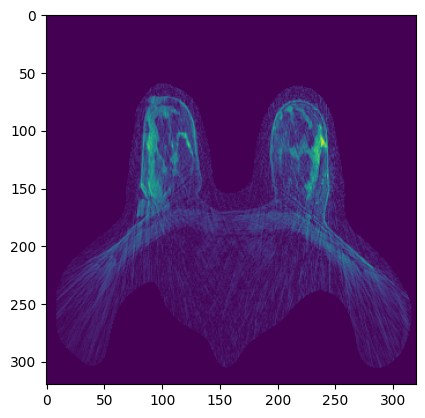

In [56]:
import matplotlib.pyplot as plt

device = torch.device("cuda")

for measured_kspace, csmap, grasp_img, N_samples, N_spokes, N_time in train_loader:

    ktraj, dcomp, nufft_ob, adjnufft_ob = prep_nufft(N_samples, N_spokes, N_time)
    ktraj = ktraj.to(device)
    dcomp = dcomp.to(device)
    nufft_ob = nufft_ob.to(device)
    adjnufft_ob = adjnufft_ob.to(device)

    physics = MCNUFFT(nufft_ob, adjnufft_ob, ktraj, dcomp)

    # with autocast(config["training"]["device"]):


    measured_kspace = to_torch_complex(measured_kspace).squeeze()
    measured_kspace = rearrange(measured_kspace, 't co sp sam -> co (sp sam) t')

    csmap = csmap.to(device).to(measured_kspace.dtype)


    x_init = physics(inv=True, data=measured_kspace.to(device), smaps=csmap)

    plt.imshow(np.abs(x_init[..., 0].cpu().numpy()))

    break

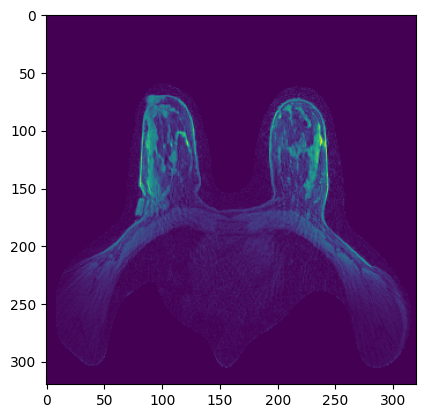

In [57]:
grasp_img = grasp_img[:, 0, ...] + 1j * grasp_img[:, 1, ...]
plt.imshow(np.abs(grasp_img.squeeze()[0].cpu().numpy()))

image shape:  torch.Size([320, 320, 8])
image shape:  <class 'torch.Tensor'>


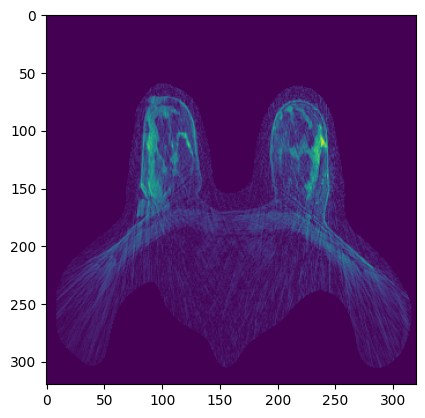

In [58]:
import matplotlib.pyplot as plt

device = torch.device("cuda")

for measured_kspace, csmap, grasp_img, N_samples, N_spokes, N_time in train_loader:

    ktraj, dcomp, nufft_ob, adjnufft_ob = prep_nufft(N_samples, N_spokes, N_time)
    ktraj = ktraj.to(device)
    dcomp = dcomp.to(device)
    nufft_ob = nufft_ob.to(device)
    adjnufft_ob = adjnufft_ob.to(device)

    physics = MCNUFFT(nufft_ob, adjnufft_ob, ktraj, dcomp)

    # with autocast(config["training"]["device"]):


    measured_kspace = to_torch_complex(measured_kspace).squeeze()
    measured_kspace = rearrange(measured_kspace, 't co sp sam -> co (sp sam) t')

    csmap = csmap.to(device).to(measured_kspace.dtype)


    x_init = physics(inv=True, data=measured_kspace.to(device), smaps=csmap)

    print("image shape: ", x_init.shape)
    print("image shape: ", type(x_init))

    plt.imshow(np.abs(x_init[..., 0].cpu().numpy()))

    break

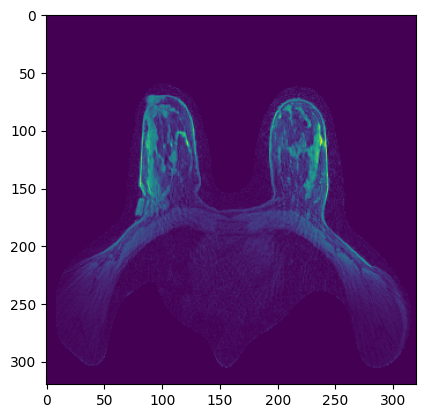

In [39]:

grasp_img = grasp_img[:, 0, ...] + 1j * grasp_img[:, 1, ...]
plt.imshow(np.abs(grasp_img.squeeze()[0].cpu().numpy()))